In [392]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [393]:
# Utility functions

def prepare(X, y=None, train=True):
    if train:
        X.drop(labels='id', axis=1, inplace=True)
        if y is not None: 
            y.drop(labels='id', axis=1, inplace=True)
    X.fillna(X.median(), inplace=True)
    X.drop_duplicates(inplace=True)
    mask_ = X.var(axis=0) != 0
    X = X.loc[:, mask_]
    
    if train:
        return X, y 
    else:
        return X
    
def save_pd(X):
    return X.index, X.columns

In [394]:
# Read csv, do data preprocessing

X, y = pd.read_csv('task-1-brain-age-prediction/X_train.csv'), pd.read_csv('task-1-brain-age-prediction/y_train.csv')
X, y = prepare(X, y)
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test = prepare(X_test, train=False)

In [395]:
X_index, X_columns = save_pd(X)
X_test_id = X_test['id']
X_test.drop(labels='id', axis=1, inplace=True)
X_test_index, X_test_columns = save_pd(X_test)

In [396]:
# Outlier detection

from sklearn.preprocessing import RobustScaler, QuantileTransformer

rbc = RobustScaler()
X_ = rbc.fit_transform(X)
X_test_ = rbc.transform(X_test)

# I don't find that transforming gives us a lot tbh ..., see the pngs
# qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
# X = qt.fit_transform(X)
# X_test = qt.transform(X_test)

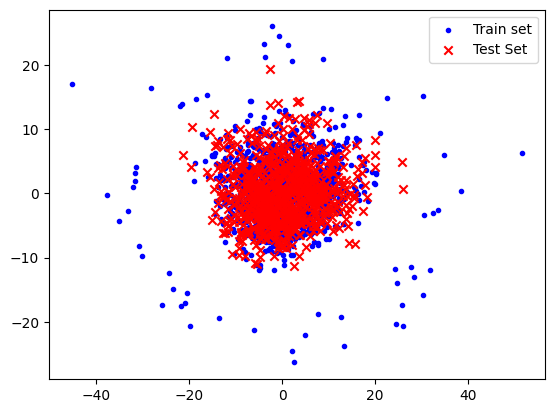

In [397]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_project = pca.fit_transform(X_)
X_test_project = pca.transform(X_test_)

fig, ax = plt.subplots()
ax.scatter(x=X_project[:, 0], y=X_project[:, 1], marker='.', color='blue')
ax.scatter(x=X_test_project[:, 0], y=X_test_project[:, 1], marker='x', color='red')
ax.legend(['Train set', 'Test Set'])
plt.show()

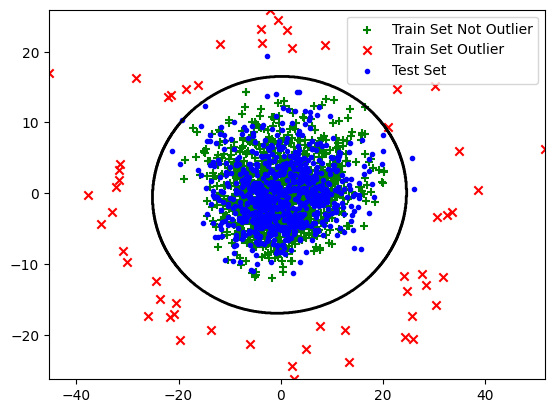

In [398]:
# Outlier Detection
# Some motivation for this approach --> since we're trying to maximize 
# r2 score on the test set and we don't have the gt label for the test set
# we only have to consider the points int the training set that are in accordance with 
# the points in the test set, i.e the outliers are the points which are far of the elliptic
# envelope decision boundary

from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

fig, ax = plt.subplots()

pca = PCA(n_components=2)
X_project = pca.fit_transform(X_)
X_test_project = pca.transform(X_test_)

# Outlier analysis --> EllipticEnvelope (Gaussian)
xx, yy = np.meshgrid(np.linspace(X_project[:, 0].min(), \
X_project[:, 0].max(), 1000), np.linspace(X_project[:, 1].min(), \
    X_project[:, 1].max(), 1000))

elliptic = EllipticEnvelope(contamination=0.046)
outliers = elliptic.fit_predict(X_project)
mask_outliers_out = outliers != -1
X_project_not_outliers = X_project[mask_outliers_out, :]
X_project_outliers = X_project[~mask_outliers_out, :]

ax.scatter(X_project_not_outliers[:, 0], X_project_not_outliers[:, 1], marker='+', color='green')
ax.scatter(X_project_outliers[:, 0], X_project_outliers[:, 1], marker='x', color='red')
ax.scatter(X_test_project[:, 0], X_test_project[:, 1], marker='.', color='blue')
Z = elliptic.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
ax.legend(['Train Set Not Outlier', 'Train Set Outlier', 'Test Set'])

plt.show()

In [399]:
# Number of outliers in this case is 
print((outliers == -1).sum())

56


In [386]:
# Back to pandas
# X = pd.DataFrame(X, index=X_index, columns=X_columns)
# X_test = pd.DataFrame(X_test, index=X_test_index, columns=X_test_columns)

In [400]:
# Outlier removal for X and y
X = X.loc[mask_outliers_out, :]
y = y.loc[mask_outliers_out, :]

In [401]:
# compute the feature_corr
print(f'Shape before feature selection (X) is {(X.shape)}')
feature_corr = X.corrwith(y.squeeze()) > 0.1
X = X.loc[:, feature_corr]
print(f'Shape after feature selection (X) is {(X.shape)}')

Shape before feature selection (X) is (1156, 828)
Shape after feature selection (X) is (1156, 37)


In [402]:
def filter_multicolinearity(X_train, sigma):
    corr_matrix = np.triu(np.corrcoef(X_train, rowvar=False))
    np.fill_diagonal(corr_matrix, val=0)
    mask_multicorr = (corr_matrix < sigma).all(axis=1)
    return mask_multicorr

print(f'Shape before feature selection (X) is {(X.shape)}')
sigma_th = 0.8
mask_features = filter_multicolinearity(X, sigma_th)
X = X.loc[:, mask_features]
print(f'Shape after feature selection (X) is {(X.shape)}')

Shape before feature selection (X) is (1156, 37)
Shape after feature selection (X) is (1156, 17)


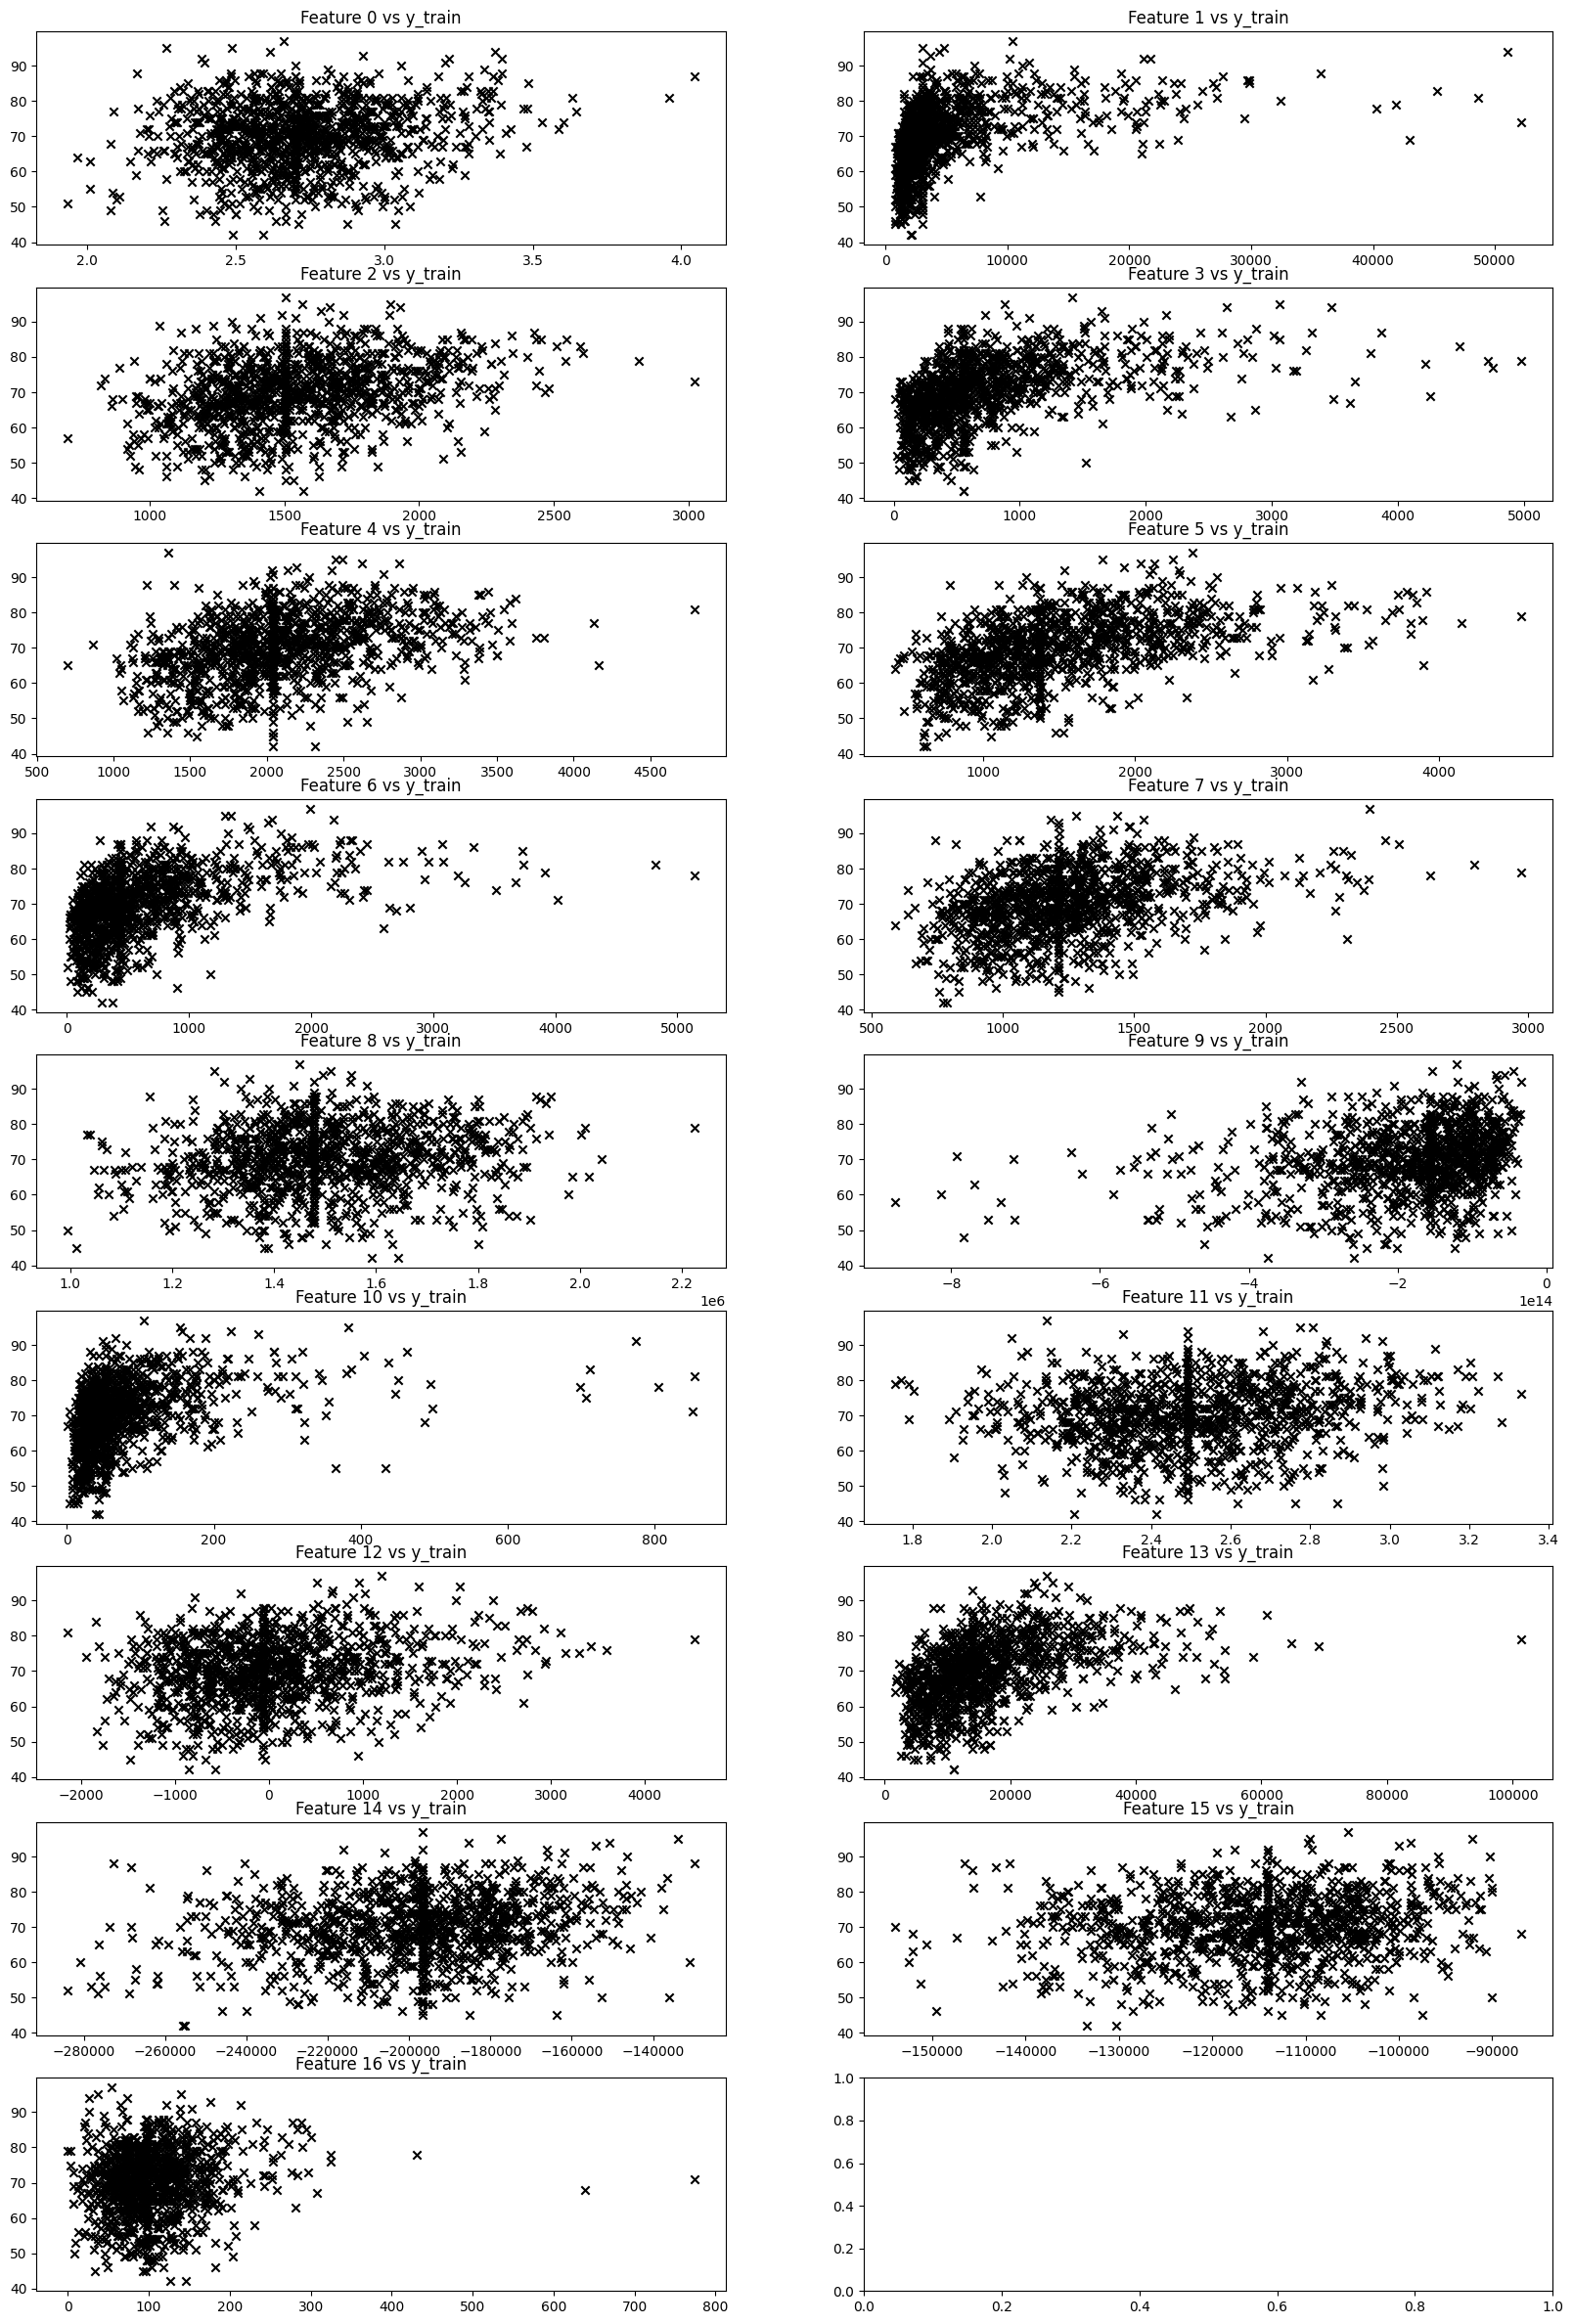

In [403]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(9, 2, figsize=(20, 30))
for i in range(17):
    axes[i // 2, i % 2].scatter(X.iloc[:, i], y, marker='x', color='black')
    axes[i // 2, i % 2].set_title(f'Feature {i} vs y_train')

plt.show()

In [404]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [405]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score 
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score

pipeline_svr = make_pipeline(RobustScaler(), SVR())
param_grid_svr = {
    'svr__kernel': ['linear', 'rbf', 'poly'], 
    'svr__gamma': ['scale', 'auto'], 
    'svr__C': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
}

grid_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid_svr.fit(X_train, y_train)

print(f'R2 score on train data {r2_score(y_train, grid_svr.predict(X_train))}')
print(f'R2 score on test data {r2_score(y_test, grid_svr.predict(X_test))}')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-

R2 score on train data 0.6728163018232038
R2 score on test data 0.5668390555675642


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [406]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.preprocessing import StandardScaler

pipeline_gpr = make_pipeline(StandardScaler(), GaussianProcessRegressor())
param_grid_gpr = {
    'gaussianprocessregressor__kernel': [RBF(), Matern(), RationalQuadratic()], 
    'gaussianprocessregressor__alpha': [1e-10, 1e-9, 1e-8, 1e-5, 1e-3, 1e-1], 
    'gaussianprocessregressor__n_restarts_optimizer': [10, 20]
}

grid_gpr = GridSearchCV(pipeline_gpr, param_grid_gpr, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid_gpr.fit(X_train, y_train)

print(f'R2 score on train data {r2_score(y_train, grid_gpr.predict(X_train))}')
print(f'R2 score on test data {r2_score(y_test, grid_gpr.predict(X_test))}')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R2 score on train data 0.9910332857856606
R2 score on test data 0.5736049250131059


In [ ]:
grid_grp.best_params_

In [407]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler

random_forest_regressor = Pipeline([ 
    ('scaler', RobustScaler()),                               
    ('random_forest_regressor', RandomForestRegressor())
])
param_grid_rd = { 
    'random_forest_regressor__n_estimators' : [50, 100, 150, 200, 250], 
    'random_forest_regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_forest_regressor__max_depth' : [3, 5, 7, 9, 11, 13, 15, 17]
}

grid_rd = GridSearchCV(estimator=random_forest_regressor, param_grid=param_grid_rd, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid_rd.fit(X_train, y_train.squeeze())

random_forest_regressor_best_estimator = grid_rd.best_estimator_

r2_score_train = r2_score(y_train, random_forest_regressor_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, random_forest_regressor_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.9313373381135002
Test r2 score: 0.5914276205648634
----


In [409]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures

kernel_ridge_regressor = Pipeline([ 
    ('scaler', StandardScaler()),
    ('kernel_ridge', KernelRidge())
])

param_grid = { 
    'kernel_ridge__alpha' : [1e-2, 1e-1, 1, 1e1, 1e2, 1e3], 
    'kernel_ridge__kernel': ['poly', 'rbf', 'linear', 'laplacian'],
}

grid = GridSearchCV(estimator=kernel_ridge_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

kernel_ridge_regressor_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, kernel_ridge_regressor_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, kernel_ridge_regressor_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.9508322119474928
Test r2 score: 0.595785365093576
----


In [410]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

extra_tree_reg = Pipeline([ 
    ('scaler', StandardScaler()),
    ('tree_reg', ExtraTreesRegressor())
])

param_grid = { 
    'tree_reg__n_estimators' : [50, 100, 150, 200, 250, 300], 
    'tree_reg__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'tree_reg__max_depth': [3, 5, 7, 9, 10, 13, 15, 17], 
    'tree_reg__max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(estimator=extra_tree_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

extra_tree_reg_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, extra_tree_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, extra_tree_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----
Train r2 score: 0.9965774597161556
Test r2 score: 0.6302112331471814
----


In [411]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import SplineTransformer

knn_reg = Pipeline([ 
    ('scaler', QuantileTransformer(n_quantiles=X_train.shape[0], output_distribution='normal')),
    ('knn_reg', KNeighborsRegressor())
])

param_grid = { 
    'knn_reg__n_neighbors' : [5, 10, 15, 20, 25, 30, 35],
    'knn_reg__weights' : ['uniform', 'distance'], 
    'knn_reg__metric': ['euclidean', 'l1', 'l2', 'manhattan']
}

grid = GridSearchCV(estimator=knn_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

knn_reg_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, knn_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, knn_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (867) is greater than the total number of samples (693). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (867) is greater than the total number of samples (693). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (867) is greater than the total number of samples (694). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (867) is greater than the total number of samples (694). n_quantiles is set to n_samples.
 

----
Train r2 score: 0.9999999999999777
Test r2 score: 0.5545176959282668
----


In [412]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import GradientBoostingRegressor

gradient_booster_reg = Pipeline([ 
    ('scaler', StandardScaler()),
    ('gradient_booster_reg', GradientBoostingRegressor())
])

param_grid = { 
    'gradient_booster_reg__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 
    'gradient_booster_reg__n_estimators': [100, 150, 200, 250, 300], 
    'gradient_booster_reg__criterion': ['friedman_mse', 'squared_error'], 
    'gradient_booster_reg__max_depth': [3, 5, 7, 9, 11, 13, 15, 17]
}

grid = GridSearchCV(estimator=gradient_booster_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

gradient_booster_reg_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, gradient_booster_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, gradient_booster_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')


----
Train r2 score: 0.9333578853455439
Test r2 score: 0.5680561886038134
----


In [413]:
from sklearn.ensemble import VotingRegressor

v_reg = VotingRegressor(
    estimators=[('gpr', grid_gpr.best_estimator_), # 0.5736049250131059
     ('random_forest', random_forest_regressor_best_estimator), # 0.5914276205648634
     ('knn_reg', extra_tree_reg_best_estimator), # 0.6302112331471814
     ('kernel_ridge', kernel_ridge_regressor_best_estimator) #0.595785365093576
     ], 
    weights=[0.2, 0.2, 0.3, 0.2]
)

In [414]:
v_reg.fit(X_train, y_train)
r2_score(y_test, v_reg.predict(X_test))

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6273072020870925

In [420]:
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test = prepare(X_test, train=False)

In [416]:
v_reg.fit(X, y)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('gpr',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gaussianprocessregressor',
                                              GaussianProcessRegressor(alpha=0.1,
                                                                       kernel=RationalQuadratic(alpha=1, length_scale=1),
                                                                       n_restarts_optimizer=10))])),
                            ('random_forest',
                             Pipeline(steps=[('scaler', RobustScaler()),
                                             ('random_forest_regressor',
                                              RandomForestRegressor(criterion='abs...rror',
                                                                    max_depth=17,
                                                                    n_estimators=250))])),
                            ('knn_reg',
                             Pipeline(steps=[('scaler', StandardScaler()),
                                             ('tree_reg',
                                              ExtraTreesRegressor(criterion='poisson',
                                                                  max_depth=15,
                                                                  max_features=None,
                                                                  n_estimators=150))])),
                            ('kernel_ridge',
                             Pipeline(steps=[('scaler', StandardScaler()),
                                             ('kernel_ridge',
                                              KernelRidge(alpha=0.1,
                                                          kernel='laplacian'))]))],
                weights=[0.2, 0.2, 0.3, 0.2])

In [419]:
print(X_test.shape)

(776, 828)


In [422]:
X_test_id = X_test['id']
X_test.drop(columns=['id'], inplace=True)
X_test = X_test.loc[:, feature_corr]
X_test = X_test.loc[:, mask_features]

In [424]:
extra_tree_reg_best_estimator.fit(X, y)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('scaler', StandardScaler()),
                ('tree_reg',
                 ExtraTreesRegressor(criterion='poisson', max_depth=15,
                                     max_features=None, n_estimators=150))])

In [425]:
# Make predictions
predictions = extra_tree_reg_best_estimator.predict(X_test)

# Create a submission file
submission = pd.DataFrame({'id': X_test_id, 'y': predictions})
submission.to_csv('submission.csv', index=False)

In [408]:
pd.concat([X, y], axis=1).to_csv('feature_selection_post.csv')